# Employee Attrition Analysis and Retention Strategy

## 1.0 Introduction
This analysis is based on the [HR Data for Analytics dataset on Kaggle](https://www.kaggle.com/datasets/jacksonchou/hr-data-for-analytics) on Kaggle, which contains employee profiles from a large company. Each record represents one employee and includes features such as satisfaction level, performance evaluation, workload, salary level, and promotion history. Through exploratory data analysis, hypothesis testing, and logistic regression modeling, this analysis identifies key drivers of employee attrition and offers data-driven retention strategy recommendations.

| Variable               | Description                                                        |
|------------------------|--------------------------------------------------------------------|
| satisfaction_level     | Employee-reported job satisfaction level [0–1]                    |
| last_evaluation        | Score of employee's last performance review [0–1]                 |
| number_project         | Number of projects employee contributes to                        |
| average_monthly_hours  | Average number of hours employee worked per month                 |
| time_spend_company     | How long the employee has been with the company (years)           |
| Work_accident          | Whether or not the employee experienced an accident while at work |
| left                   | Whether or not the employee left the company                      |
| promotion_last_5years  | Whether or not the employee was promoted in the last 5 years      |
| sales             | The employee's department                                         |
| salary                 | The employee's salary (U.S. dollars)                              |


In [1]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

# For testing
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

In [2]:
df = pd.read_csv("data/HR_comma_sep.csv")

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2.0 Initial Data Exploration and Data Cleaning

In [3]:
# Basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Descriptive statistics of numerical data
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Basic statistics of categorical data
df.describe(include='object')

,sales,salary
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


In [6]:
df['sales'].value_counts()

sales
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64

In [7]:
df['salary'].value_counts()

salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64

In [8]:
# Display all column names
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [9]:
# Rename columns as needed
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'sales': 'department'})

# Display all column names after the update
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [10]:
# Check for missing values
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [11]:
# Check for duplicates
df.duplicated().sum()

3008

In [12]:
# Inspect some rows containing duplicates
df[df.duplicated(keep=False)].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [13]:
# Inspect rows that are identical to the first row
df[df.eq(df.iloc[0]).all(axis=1)]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
12000,0.38,0.53,2,157,3,0,1,0,sales,low
14211,0.38,0.53,2,157,3,0,1,0,sales,low


In [14]:
# The likelihood of getting 10 columns the same based on each column's frequency
def row_likelihood(df, row):
    prob = 1.0
    for col in df.columns:
        val = row[col]
        freq = (df[col] == val).mean()
        if freq == 0:
            freq = 1e-9  # avoid zero-probability
        prob *= freq
    return prob

row = df.iloc[0]
likelihood = row_likelihood(df, row)
expected_occurrences = likelihood * len(df)
print(f"Estimated likelihood of row: {likelihood:.2e}")
print(f"Expected number of such rows: {expected_occurrences:.2f}")

Estimated likelihood of row: 4.20e-09
Expected number of such rows: 0.00


In [15]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df.drop_duplicates(keep='first')

df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [16]:
df1.to_csv("data/clean_hr_data.csv", index=False)

### 2.1 Summary of Initial Exploration and Cleaning

1. Renaming columns: based on the business meanings of columns, some columns are renamed, such as "sales" looks like a typo and is renamed to "department"; some columns are renamed to match the "snake_case".
2. Checking missing values: no missing values and all columns have 14,999 records.
3. Checking abnormal values: based on the understanding of business meanings of each column check the column values, for example, `satisfaction_level` and `last_evaluation` should only contain values between 0 and 1. No abnormal values.
4. Removing duplicates: there are 3008 duplicated rows which is 20% of the data. Based on likelihood analysis, it is very unlikely that these duplicated observations are legitimate. So, these rows are dropped.

## 3.0 Attrition Rate Analysis

In [17]:
total = len(df1)
stayed = df1['left'].value_counts().get(0, 0)
left = df1['left'].value_counts().get(1, 0)
turnover_rate = left / total * 100

print(f"Employee Turnover Summary")
print(f"---------------------------")
print(f"Total number of employees: {total:,}")
print(f"Stayed employees:          {stayed:,}")
print(f"Left employees:            {left:,}")
print(f"Turnover rate:             {turnover_rate:.2f}%")

Employee Turnover Summary
---------------------------
Total number of employees: 11,991
Stayed employees:          10,000
Left employees:            1,991
Turnover rate:             16.60%


Through the statistics of the data set, it is found that 1,991 employees have been lost in history, with an average turnover rate of 16.60%.

### 3.1 Employee Distribution by Tenure and Attrition Rate

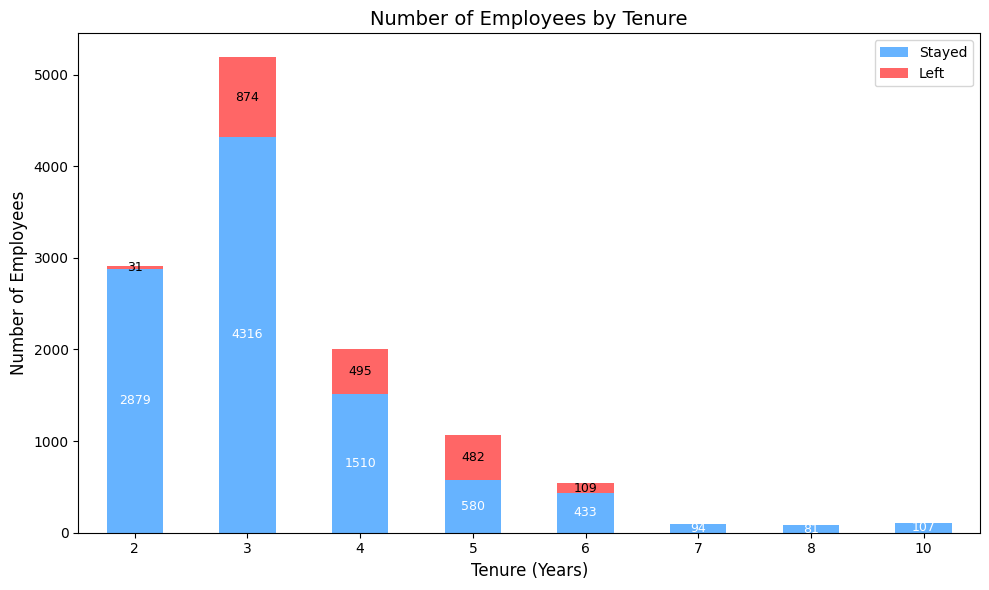

In [18]:
# Number of stayed/left employees in each tenure group
tenure_counts = df1.groupby(['tenure', 'left']).size().unstack(fill_value=0)
tenure_counts = tenure_counts.sort_index()

# Draw stacked bar chart
ax = tenure_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#66b3ff', '#ff6666'])
plt.title('Number of Employees by Tenure', fontsize=14)
plt.xlabel('Tenure (Years)', fontsize=12)
plt.ylabel('Number of Employees', fontsize=12)
plt.legend(['Stayed', 'Left'])
plt.xticks(rotation=0)
plt.tight_layout()

# Add labels
for i, (index, row) in enumerate(tenure_counts.iterrows()):
    stayed = row.get(0, 0)
    left = row.get(1, 0)

    # stayed label
    if stayed > 0:
        ax.text(i, stayed / 2, str(stayed), ha='center', va='center', fontsize=9, color='white')

    # left label
    if left > 0:
        ax.text(i, stayed + left / 2, str(left), ha='center', va='center', fontsize=9, color='black')

plt.show()

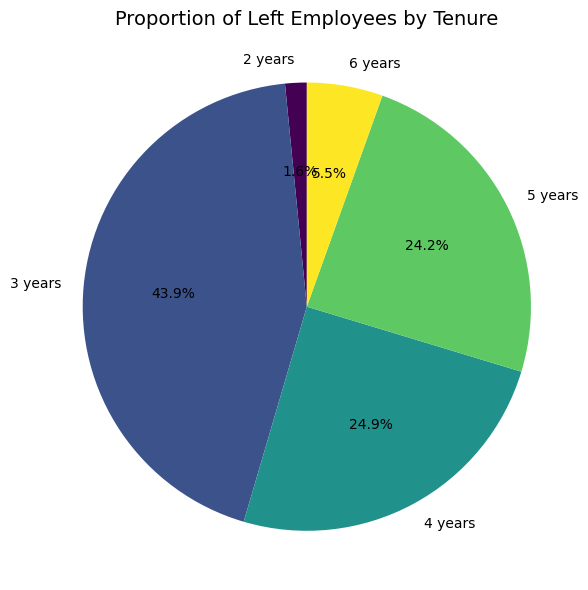

In [19]:
left_df = df1[df1['left'] == 1]

# Compute left employees for each tenure
tenure_left_counts = left_df['tenure'].value_counts().sort_index()
tenure_labels = [f'{int(x)} years' for x in tenure_left_counts.index]

cmap = colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(tenure_left_counts)))

# Draw pie chart
plt.figure(figsize=(6,6))
plt.pie(
    tenure_left_counts,
    labels=tenure_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Proportion of Left Employees by Tenure', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

From the above two charts we could get the following insights:
1. Analyzing the tenure of employees who left reveals that those with 3 to 5 years of service had the highest attrition counts, with 3-year-tenure employees being the most affected (874 individuals). Employees with more than 6 years of tenure showed minimal attrition, indicating relative stability.

2. Among all employees who left the company, those with 3 years of tenure accounted for 43.9%, 4-year-tenure employees for 24.9%, 5-year-tenure employees for 24.2%, and 6-year-tenure employees for 6.5%.

#### 3.1.1 Hypothesis Testing on Tenure Groups
To further analyze the relation between tenure and employee status, we can perform a hypothesis test.

$ H_0 $: There is no significant difference in attrition rate among different tenure groups\
$ H_A $: There is a significant difference in attrition rate among different tenure groups

In [20]:
# Create contingency table
contingency_table = pd.crosstab(df1['tenure'], df1['left'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

result = {
    'Chi-squared Statistic': round(chi2, 4),
    'Degrees of Freedom': dof,
    'p-value': round(p, 4),
    'Conclusion': 'Reject null hypothesis (dependent)' if p < 0.05 else 'Fail to reject null (independent)'
}

result

{'Chi-squared Statistic': 1298.5556,
 'Degrees of Freedom': 7,
 'p-value': 0.0,
 'Conclusion': 'Reject null hypothesis (dependent)'}

The result of this hypothesis test align with the graph insights. Under different tenure groups, the attrition rate has a significant difference, that is, the tenure of employees affects the attrition rate. And from the graph insights, most turnover happens in the 3-to-5-year tenure group. Thus, we will further analyze other attributes of the 3-to-5-year tenure group, to find what causes these employees left the company.

### 3.2 Further exploration on the 3-to-5-year tenure group

In [21]:
# Statistics for the 3-to-5-year tenure group
df1 = df1.copy()
df1.loc[:, 'tenure_group'] = df1['tenure'].apply(lambda x: '3-5 years' if x in [3, 4, 5] else 'Others')

In [22]:
grouped_continuous = df1.groupby(['tenure_group', 'left'])[
    ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours']
].mean().round(3).reset_index()

grouped_continuous['left'] = grouped_continuous['left'].map({0: 'stayed', 1: 'left'})
grouped_continuous

,tenure_group,left,satisfaction_level,last_evaluation,number_project,average_monthly_hours
0,3-5 years,stayed,0.663,0.717,3.817,198.542
1,3-5 years,left,0.418,0.710,3.840,206.152
2,Others,stayed,0.675,0.714,3.734,199.657
3,Others,left,0.741,0.874,4.464,234.736


For employees with 3–5 years of tenure:
* The average job **satisfaction** of those who left is significantly lower than that of those who stayed.
* Their **performance evaluations** are slightly lower than those of retained employees.
* Employees who left completed slightly more **projects** and had slightly higher **average monthly working hours**.

In [23]:
binary_vars = ['work_accident', 'promotion_last_5years']

# Compute the proportion
grouped_binary = df1.groupby(['tenure_group', 'left'])[binary_vars].mean().round(4) * 100
grouped_binary = grouped_binary.reset_index()

grouped_binary['left'] = grouped_binary['left'].map({0: 'stayed', 1: 'left'})

for col in binary_vars:
    grouped_binary[col] = grouped_binary[col].map(lambda x: f'{x:.1f}%')

grouped_binary

,tenure_group,left,work_accident,promotion_last_5years
0,3-5 years,stayed,17.2%,1.8%
1,3-5 years,left,5.4%,0.4%
2,Others,stayed,17.9%,2.2%
3,Others,left,3.6%,0.0%


* Among employees with 3–5 years of tenure who are still with the company, 17.2% have experienced a work accident, and 1.8% have been promoted in the past five years.
* Among those with 3–5 years of tenure who have left the company, only 5.4% experienced a work accident, and just 0.4% were promoted.
* Among employees with other tenures (not 3–5 years) who stayed, 17.9% experienced a work accident, and 2.2% had a promotion.
* Among those with other tenures who left the company, only 3.6% experienced a work accident, and none were promoted.

* Work accident rate: Retained employees have a higher accident rate than those who left, especially in the 3–5 year group (17.2% vs. 5.4%).
* Promotion rate: Employees who stayed have significantly higher promotion rates, suggesting a strong association between promotion opportunities and employee retention.
* Among all employees who left, promotion rates are extremely low—particularly in the non-3–5-year group, where the promotion rate is 0%.

In [24]:
# Salary summary for the 3-to-5-year tenure group
salary_order = ['low', 'medium', 'high']

total_35 = df1[df1['tenure_group'] == '3-5 years'].shape[0]
left_35 = df1[(df1['tenure_group'] == '3-5 years') & (df1['left'] == 1)]
stayed_35 = df1[(df1['tenure_group'] == '3-5 years') & (df1['left'] == 0)]

left_salary_counts = left_35['salary'].value_counts().reindex(salary_order, fill_value=0)
stayed_salary_counts = stayed_35['salary'].value_counts().reindex(salary_order, fill_value=0)

left_salary_proportion = (left_salary_counts / total_35 * 100).round(1)
stayed_salary_proportion = (stayed_salary_counts / total_35 * 100).round(1)

summary_salary = pd.DataFrame({
    'Salary Level': salary_order,
    'Left Count': left_salary_counts.values,
    'Left %': [f'{v:.1f}%' for v in left_salary_proportion.values],
    'Stayed Count': stayed_salary_counts.values,
    'Stayed %': [f'{v:.1f}%' for v in stayed_salary_proportion.values]
})
summary_salary

,Salary Level,Left Count,Left %,Stayed Count,Stayed %
0,low,1095,13.3%,2960,35.8%
1,medium,708,8.6%,2868,34.7%
2,high,48,0.6%,578,7.0%


* Overall, Low and Medium salary employees dominate all groups and high salary employees are a small minority, possibly due to delayed promotions or pay structure.
* Attrition is higher among lower-paid employees. Low salary employees account for over half (13.3% out of 21.9%) of all attrition in this tenure group. The lower the salary, the higher the attrition risk.

#### 3.2.1 Hypothesis Testing on 3-5 years Tenure Groups

In [25]:
df_35 = df1[df1['tenure_group'] == '3-5 years']

left = df_35[df_35['left'] == 1]
stayed = df_35[df_35['left'] == 0]

In [26]:
# T test for continuous variables
def compare_means(var):
    t_stat, p_val = ttest_ind(left[var], stayed[var], equal_var=False)
    print(f'{var} - p-value: {p_val:.4f} | {"Significant" if p_val < 0.05 else "Not significant"}')

for col in ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours']:
    compare_means(col)

satisfaction_level - p-value: 0.0000 | Significant
last_evaluation - p-value: 0.2049 | Not significant
number_project - p-value: 0.6100 | Not significant
average_monthly_hours - p-value: 0.0000 | Significant


In [27]:
# Z test for binomial variables
def z_test_prop(var):
    count = [left[var].sum(), stayed[var].sum()]
    nobs = [len(left), len(stayed)]
    stat, p_val = proportions_ztest(count, nobs)
    print(f'{var} - p-value: {p_val:.4f} | {"Significant" if p_val < 0.05 else "Not significant"}')

for col in ['work_accident', 'promotion_last_5years']:
    z_test_prop(col)

work_accident - p-value: 0.0000 | Significant
promotion_last_5years - p-value: 0.0000 | Significant


In [28]:
# Chi-square test for salary
salary_table = pd.crosstab(df_35['salary'], df_35['left'])

chi2, p_val, dof, expected = chi2_contingency(salary_table)
print(f'Salary vs Left - p-value: {p_val:.4f} | {"Significant" if p_val < 0.05 else "Not significant"}')

Salary vs Left - p-value: 0.0000 | Significant


In the 3-5-year tenure group:
\
**Significant Differences (p < 0.05):**
* satisfaction_level: Employees who left had significantly lower satisfaction.
* average_monthly_hours: Employees who left worked significantly more hours per month.
* work_accident: Those who left had significantly fewer work accidents.
* promotion_last_5years: Those who left were significantly less likely to have been promoted.
* salary: The salary distribution differed significantly between employees who left and those who stayed.

**No Significant Differences (p ≥ 0.05):**
* last_evaluation: No significant difference in performance evaluation scores.
* number_project: No significant difference in the number of projects completed.

Overall, the hypothesis testing results align closely with our earlier observational findings. For employees with 3–5 years of tenure, satisfaction level, work accident history, promotion status, and salary level show significant associations with attrition. 

Among the variables that showed slight differences in our exploratory analysis—average monthly hours, last evaluation, and number of projects—only average monthly hours proved to be statistically significant. 

### 3.3 Departments and Attrition Rate

While tenure appeared to be the strongest factor driving attrition, we also observed visible differences in attrition across departments.
In this section, we analyze attrition at the department level for all employees, to assess whether organizational structure plays a role in employee turnover.

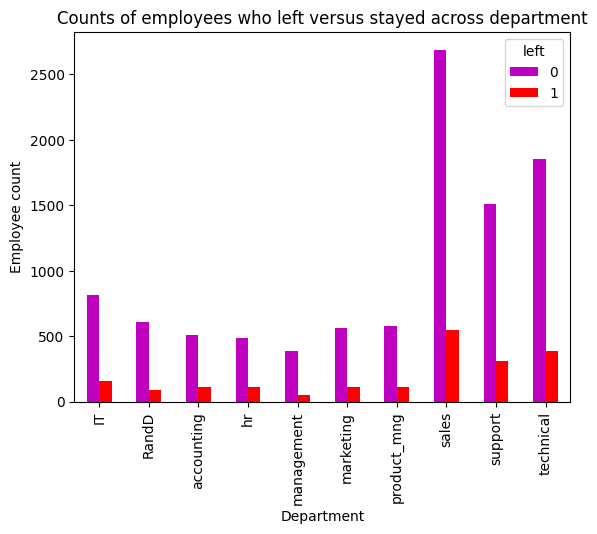

In [29]:
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [30]:
dept_counts = df1.groupby(['department', 'left']).size().unstack(fill_value=0)
dept_counts.columns = ['Stayed', 'Left']
dept_counts['Total'] = dept_counts['Stayed'] + dept_counts['Left']
dept_counts['Attrition Rate (%)'] = (dept_counts['Left'] / dept_counts['Total'] * 100).round(2)

dept_summary = dept_counts.reset_index()

dept_summary_sorted_dual = dept_summary.sort_values(
    by=['Attrition Rate (%)', 'Total'],
    ascending=[False, False]
).reset_index(drop=True)

dept_summary_sorted_dual

,department,Stayed,Left,Total,Attrition Rate (%)
0,hr,488,113,601,18.80
1,accounting,512,109,621,17.55
2,technical,1854,390,2244,17.38
3,support,1509,312,1821,17.13
4,sales,2689,550,3239,16.98
5,marketing,561,112,673,16.64
6,IT,818,158,976,16.19
7,product_mng,576,110,686,16.03
8,RandD,609,85,694,12.25
9,management,384,52,436,11.93


In [31]:
# Chi-square test for Departments
dept_crosstab = pd.crosstab(df1['department'], df1['left'])
chi2, p, dof, expected = chi2_contingency(dept_crosstab)

result = {
    'Chi-squared Statistic': round(chi2, 4),
    'Degrees of Freedom': dof,
    'p-value': round(p, 4),
    'Conclusion': 'Reject null hypothesis (dependent)' if p < 0.05 else 'Fail to reject null (independent)'
}

result

{'Chi-squared Statistic': 20.8575,
 'Degrees of Freedom': 9,
 'p-value': 0.0133,
 'Conclusion': 'Reject null hypothesis (dependent)'}

From the two charts above, we observe that the attrition rates for most departments fall between 16% and 18%, with the HR department having the highest attrition rate at 18.8%. In contrast, R&D and Management departments show significantly lower attrition rates, at 12.25% and 11.93%, respectively.

A chi-square test of independence confirms this observation: at the 95% confidence level, we find statistical evidence that the department an employee belongs to is significantly associated with their likelihood of attrition. In other words, attrition is not independent of department—some departments exhibit notably higher or lower turnover rates, which aligns with the trends seen in our visualizations.

Moving forward, we will build a logistic regression model to assess the independent effect and direction of each variable while controlling for potential confounders.

## 4.0 Logistic Regression on Attrition Drivers

To further assess the independent effects of each factor on attrition, we built a logistic regression model while controlling for potential confounders. This allows us to evaluate the direction and significance of each variable's contribution to attrition.

In [32]:
features = ['satisfaction_level', 'last_evaluation', 'number_project',
            'average_monthly_hours', 'work_accident', 'promotion_last_5years']

df_dummies = pd.get_dummies(df1[['salary', 'department']], drop_first=False)
df_dummies = df_dummies.drop(columns=['salary_high', 'department_RandD'])

X = pd.concat([df1[features], df_dummies], axis=1)
X = sm.add_constant(X)
X = X.astype(float)
y = df1['left']


model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.367209
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                11991
Model:                          Logit   Df Residuals:                    11973
Method:                           MLE   Df Model:                           17
Date:                Fri, 28 Mar 2025   Pseudo R-squ.:                  0.1832
Time:                        12:35:44   Log-Likelihood:                -4403.2
converged:                       True   LL-Null:                       -5390.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.4730      0.246     -5.990      0.000      -1.955      

**Employee Attributes**
* `satisfaction_level`: Significant. Higher satisfaction is strongly associated with lower attrition. This aligns with both visualization and t-test results.

* `average_monthly_hours`: Significant. Longer working hours are associated with higher attrition risk, supporting the "overwork" hypothesis. Matches both visual and univariate findings.

* `work_accident`: Significant. Employees with a work accident are less likely to leave, possibly due to company protection, reassignment, or simply longer tenure leading to higher accident exposure. Consistent with observed trends.

* `promotion_last_5years`: Significant. Employees who were promoted are more likely to stay, indicating promotion is a strong retention factor. Matches both visual and statistical observations.

* `last_evaluation`: Significant. Higher evaluation scores are associated with slightly higher attrition risk. This variable was not significant in univariate testing, but became significant after controlling for confounders like satisfaction, project count, and working hours.

* `number_project`: Significant. More project involvement is linked to lower attrition, possibly indicating stronger engagement. Not significant in univariate tests but revealed significance after controlling for other variables.

**Salary Level (Reference: High)**
* `salary_low`: Significant. Low-salary employees are much more likely to leave compared to high-salary ones. This is consistent with the salary table and hypothesis testing.

* `salary_medium`: Significant. Employees with medium salaries are more likely to leave than those with high salaries, but less so than low-salary employees. Matches previous observations.

**Department (Reference: R&D)**
* The following departments show significantly higher attrition compared to R&D, consistent with visual observations: `IT`, `accounting`, `hr`, `marketing`, `sales`, `support`, and `technical`.

* `management`: Not significant, indicating similar attrition rate to R&D. This aligns with prior observation.

* `product_mng`: Not significant, which contradicts the visual trend slightly. This may be due to a smaller sample size leading to insufficient statistical power.

## 5.0 Data-Driven Recommendations

1. **Optimize Compensation Structure to Reduce Turnover Among Low-Salary Employees**
* Analysis shows that employees with low salaries are significantly more likely to leave compared to those with medium or high salaries. Salary level is one of the key drivers of attrition.
* Recommendation: Adjust the balance between base pay and performance bonuses. For frontline and entry-level positions, consider implementing a minimum guaranteed income policy to enhance employee retention.

2. **Incorporate Employee Satisfaction into Performance and Talent Management**
* Satisfaction level is one of the most significant predictors of attrition. It is recommended to include satisfaction as a metric in team performance evaluations.
* Recommendation: For employees with persistently low satisfaction, provide timely interventions such as feedback, counseling, or role adjustments. For consistently satisfied employees, consider offering internal referrals or promotion opportunities.

3. **Manage Turnover Risk Among “High-Performance + Long Hours” Employees**
* Data shows that employees with high performance, heavy workloads, and long working hours are more likely to leave, possibly due to burnout or lack of recognition.
* Recommendation: Establish clear promotion pathways, flexible working policies, or introduce “high workload bonuses” to increase perceived fairness and recognition for these employees.

4. **Strengthen Promotion and Incentive Mechanisms for Employees with 3–5 Years of Tenure**
* The highest attrition rates are concentrated among employees with 3–5 years of service, especially those with low promotion rates.
* Recommendation: Introduce a “three-year service reward,” conduct mid-career promotion reviews, and hold regular career development conversations to boost employee loyalty and engagement.

5. **Enhance Retention Strategies in High-Turnover Departments (HR, Support, Sales)**
* These departments show significantly higher attrition rates compared to R&D, potentially due to high workload intensity or weaker feedback mechanisms.
* Recommendation: Conduct regular satisfaction surveys within departments, implement role rotation programs, and design clear growth paths for frontline employees to improve retention and morale.